<a href="https://colab.research.google.com/github/Davit000Asryan/My-projects/blob/main/MNIST_digit_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.transforms as transforms


In [60]:
# checking if a GPU is available and setting the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# for reproducibility
torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

In [61]:
# making a preprocessor pipeline for the data

preprocessor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.1307, std=0.3081)
])


# download the data

train_data = torchvision.datasets.MNIST(
    root = 'data',
    train = True,
    download = True,
    transform = preprocessor
)
test_data = torchvision.datasets.MNIST(
    root = 'data',
    train = False,
    download = True,
    transform = preprocessor
)


In [62]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [63]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [64]:
train_data.targets.shape

torch.Size([60000])

In [65]:
# defining a dictionary  with data loaders
from torch.utils.data import DataLoader
loaders = {
    'train' : DataLoader(train_data,
                         batch_size = 100,
                         shuffle = True),

    'test' : DataLoader(test_data,
                        batch_size = 100,
                        shuffle = True)
}

In [66]:
# neural network architecture

class Model(nn.Module):
    def __init__(self):

        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3= nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fcl1 = nn.Linear(in_features=128*7*7, out_features=64)
        self.out_layer = nn.Linear(in_features=64, out_features=10)


    # forward method with ReLu activation functions
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))
      x = self.pool1(x)
      x = F.relu(self.conv3(x))
      x = self.pool2(x)
      x = x.view(x.size(0), -1)
      x = F.relu(self.fcl1(x))
      x = self.out_layer(x)

      return x


In [67]:
# instantiating the model, optimizer and loss function
model = Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_f = nn.CrossEntropyLoss()

# creating caches for losses
train_losses = []
test_losses = []


In [68]:
# training
epochs = 15

# making a counters for calculating accuracy
train_total_correct = 0
train_total = 0


# putting the model into training mode
model.train()
print('Training started')

for epoch in range(epochs):
  for batch_idx, (train_inputs, train_labels) in enumerate(loaders['train']):

    # moving the data to the GPU
    train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)

    # making the gradients zero
    optimizer.zero_grad()

    # predicting the outputs
    train_preds = model(train_inputs)

    #count and cache the loss
    train_loss = loss_f(train_preds, train_labels)

    # using .item() to store only numeric values
    train_losses.append(train_loss.item())

    # backprop
    train_loss.backward()

    # ubdate the parameters
    optimizer.step()

    # get the predicted classes
    train_pred_classes = train_preds.argmax(dim=1)

    # compare predictions with true labels
    train_correct_predictions = (train_pred_classes == train_labels)

    # calculate the total number of correct predictions and convert to a python number
    train_total_correct += train_correct_predictions.sum().item()
    train_total += train_labels.size(0)

  # tracking the training losses
  print(f'For training epoch: {epoch+1} the avarage loss is: {np.mean(train_losses)}')

print('Training finished')

# calculate the accuracy
train_accuracy = (train_total_correct / train_total)*100

print(f'Training accuracy: {train_accuracy} %')


Training started
For training epoch: 1 the avarage loss is: 0.138841914179114
For training epoch: 2 the avarage loss is: 0.08821969587860319
For training epoch: 3 the avarage loss is: 0.06712510567140675
For training epoch: 4 the avarage loss is: 0.055065074869183564
For training epoch: 5 the avarage loss is: 0.04681859400704949
For training epoch: 6 the avarage loss is: 0.04104076755035951
For training epoch: 7 the avarage loss is: 0.036488699009061876
For training epoch: 8 the avarage loss is: 0.03308634219494498
For training epoch: 9 the avarage loss is: 0.030061322003205836
For training epoch: 10 the avarage loss is: 0.02766591369680206
For training epoch: 11 the avarage loss is: 0.025686830508080006
For training epoch: 12 the avarage loss is: 0.024032243965154312
For training epoch: 13 the avarage loss is: 0.022622443124534063
For training epoch: 14 the avarage loss is: 0.021386788599401827
For training epoch: 15 the avarage loss is: 0.020268047765292074
Training finished
Training

In [69]:
# testing

# puting the model into evaluation mode
model.eval()

test_losses = []

# making a counter for calculating the accuracy
test_total_correct = 0
test_total = 0

with torch.no_grad():
  for batch_idx, (test_inputs, test_labels) in enumerate(loaders['test']):

    # moving the data to the GPU
    test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

    # predict the valuesv
    test_preds = model(test_inputs)

    # calculate the loss for each batch and store it
    test_loss = loss_f(test_preds, test_labels)
    test_losses.append(test_loss.item())

    # get the predicted classes
    test_pred_classes = test_preds.argmax(dim=1)

    # compare predictions with true labels
    test_correct_predictions = (test_pred_classes == test_labels)

    # calculate the total number of correct predictions and convert to a python number
    test_total_correct += test_correct_predictions.sum().item()
    test_total += test_labels.size(0)


# calculate the mean test loss over all batches
mean_test_loss = sum(test_losses) / len(test_losses)

print(f'The mean test loss: {mean_test_loss}')

# calculate the accuracy
test_accuracy = (test_total_correct / test_total)*100

print(f'Testing accuracy: {test_accuracy} %')



The mean test loss: 0.029390177100740402
Testing accuracy: 99.28 %


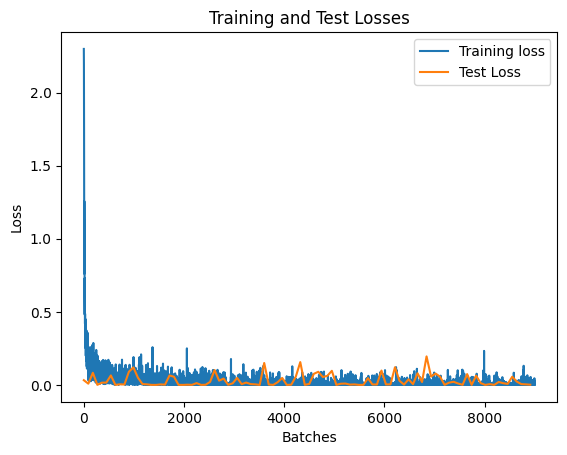

In [70]:
plt.plot(train_losses, label='Training loss')

#create X axis for testing losses
X_axis_test = [i*90 for i in range(len(test_losses))]

plt.plot(X_axis_test, test_losses, label='Test Loss')

plt.legend()
plt.title('Training and Test Losses')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.show()

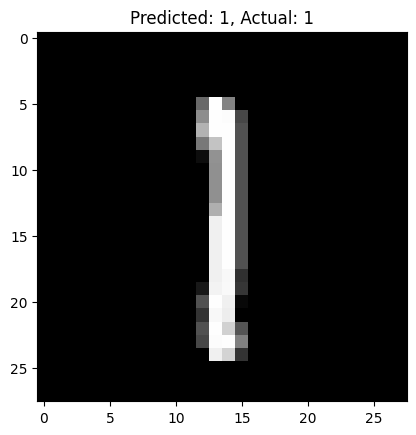

In [71]:
# printing a random sample image and its predition
import random

# selecting a random index from the test dataset
random_index = random.randint(0, len(test_data) - 1)

# getting the image and label from the test dataset
image, label = test_data[random_index]

# moveing the image to the gpu and adding a batch dimension
image = image.unsqueeze(0).to(device)

# predicting the number
with torch.no_grad():
  prediction = model(image)

plt.imshow(image.cpu().squeeze().numpy(), cmap='gray')
plt.title(f'Predicted: {label}, Actual: {label}')
plt.show()

Checking the model on my handwriting


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


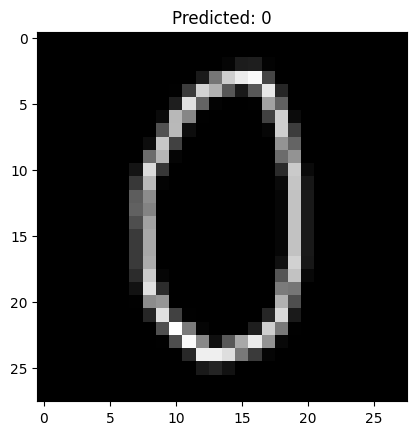

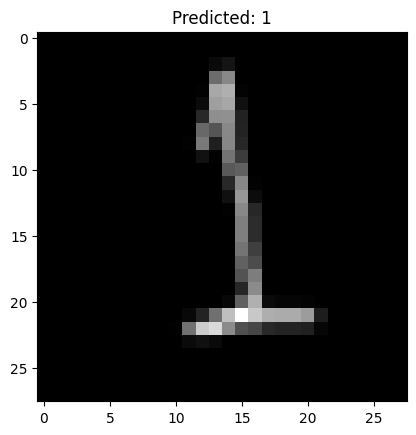

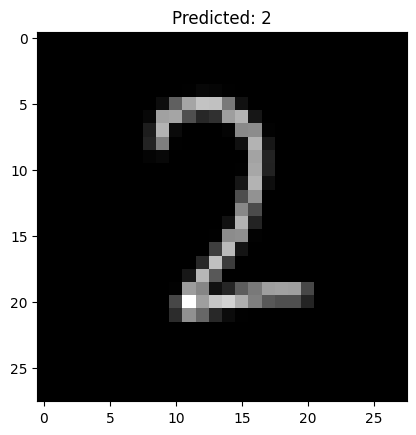

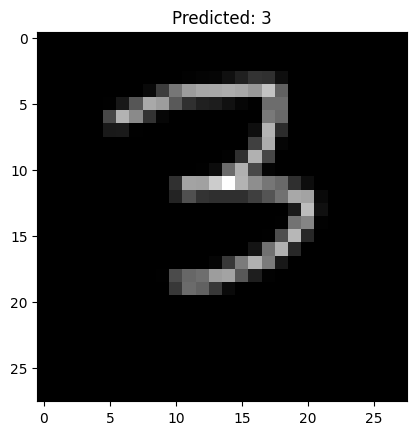

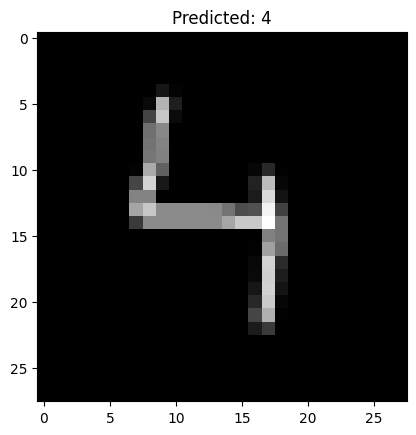

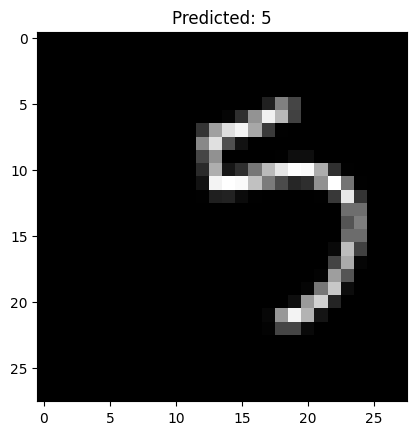

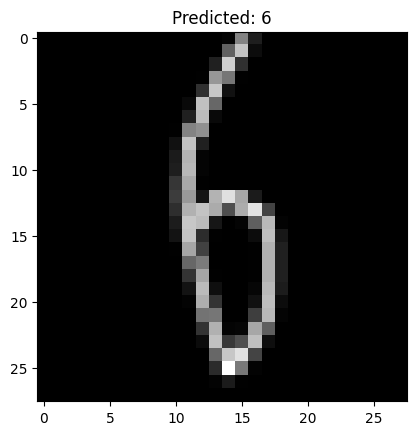

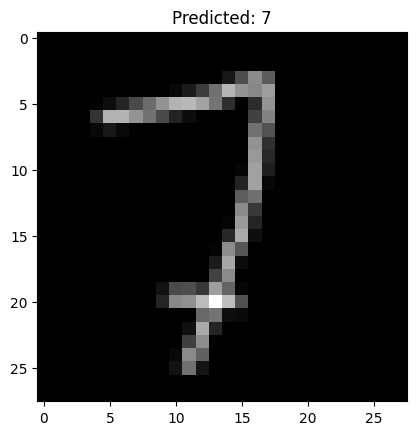

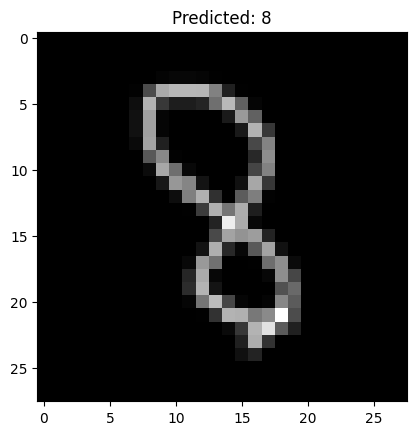

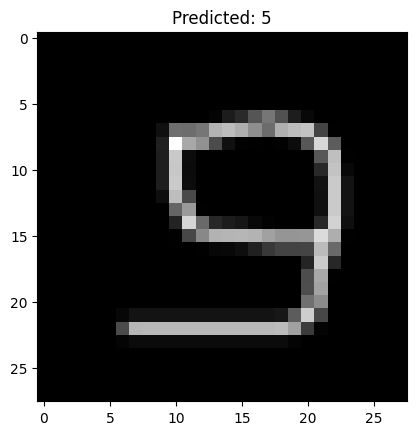

In [72]:
from PIL import Image
import os

# mounting on drive
from google.colab import drive
drive.mount('/content/drive')



# making a preprocessor pipeline for new images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.Lambda(lambda img: Image.eval(img, lambda x: 255 - x)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.1307, std=0.3081)
])

# getting the names of the files in a folder
image_folder = '/content/drive/MyDrive/MNIST digit recognition/handwriten digits'
image_files = os.listdir(image_folder)[:10]

# loading and transforming the images
images = [transform(Image.open(os.path.join(image_folder, img))) for img in image_files]
images_tensor = torch.stack(images) # put the images into a batch

# predicting the outputs
with torch.no_grad():
  images_pred = model(images_tensor.to(device))

# getting the predicted classes
predicted_classes = images_pred.argmax(dim=1)

# printing the results
for i in range(len(image_files)):
    plt.imshow(images_tensor[i].numpy().squeeze(), cmap='gray')
    plt.title(f"Predicted: {predicted_classes[i].item()}")
    plt.show()

